# **SOLUCIÓN: Pronóstico de la evolución de pacientes con diabetes**

## **Introducción**
Se quiere ajustar un modelo predictivo que permita predecir el avance de la diabetes en pacientes en base a un indicador. Se quieren comparar la capacidad de ajuste de un modelo de regresión lineal y una red neuronal.

## **Carga de librerias**

In [0]:

import pandas as pd

pd.set_option('display.float_format', lambda x: '%.4f' % x)

import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set(style='white')

#import altair as alt
from sklearn.linear_model import LinearRegression

from sklearn.neural_network import MLPRegressor

## **Carga de datos**

In [2]:
df = pd.read_csv(
    "https://github.com/ANN-2019-2/evaluacion-jfmra99/raw/master/datos/diabetes.csv",
    sep = ',',         # separador de campos
    thousands = None,  # separador de miles para números
    decimal = '.' # separador de los decimales para números
    )     

df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
0,0.0381,0.0507,0.0617,0.0219,-0.0442,-0.0348,-0.0434,-0.0026,0.0199,-0.0176,151.0000
1,-0.0019,-0.0446,-0.0515,-0.0263,-0.0084,-0.0192,0.0744,-0.0395,-0.0683,-0.0922,75.0000
2,0.0853,0.0507,0.0445,-0.0057,-0.0456,-0.0342,-0.0324,-0.0026,0.0029,-0.0259,141.0000
3,-0.0891,-0.0446,-0.0116,-0.0367,0.0122,0.0250,-0.0360,0.0343,0.0227,-0.0094,206.0000
4,0.0054,-0.0446,-0.0364,0.0219,0.0039,0.0156,0.0081,-0.0026,-0.0320,-0.0466,135.0000
...,...,...,...,...,...,...,...,...,...,...,...
437,0.0417,0.0507,0.0197,0.0597,-0.0057,-0.0026,-0.0287,-0.0026,0.0312,0.0072,178.0000
438,-0.0055,0.0507,-0.0159,-0.0676,0.0493,0.0792,-0.0287,0.0343,-0.0181,0.0445,104.0000
439,0.0417,0.0507,-0.0159,0.0173,-0.0373,-0.0138,-0.0250,-0.0111,-0.0469,0.0155,132.0000
440,-0.0455,-0.0446,0.0391,0.0012,0.0163,0.0153,-0.0287,0.0266,0.0445,-0.0259,220.0000


Del conjunto de datos se tiene que las covariables son:

- **Y**: indice de progreso de la enfermedad, variable respuesta.
- **age:** edad.
- **sex:** sexo.
- **bmi:** indice de masa corporal.
- **bp:** presión sanguinea.
- **s1, s2, s3, s4, s5 y s6:** seis medidas de serum en la sangre.


Se procede a realizar su tabla resumen:

In [3]:
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Y
count,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000
mean,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,152.1335
std,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,77.0930
min,-0.1072,-0.0446,-0.0903,-0.1124,-0.1268,-0.1156,-0.1023,-0.0764,-0.1261,-0.1378,25.0000
25%,-0.0373,-0.0446,-0.0342,-0.0367,-0.0342,-0.0304,-0.0351,-0.0395,-0.0332,-0.0332,87.0000
50%,0.0054,-0.0446,-0.0073,-0.0057,-0.0043,-0.0038,-0.0066,-0.0026,-0.0019,-0.0011,140.5000
75%,0.0381,0.0507,0.0312,0.0356,0.0284,0.0298,0.0293,0.0343,0.0324,0.0279,211.5000
max,0.1107,0.0507,0.1706,0.1320,0.1539,0.1988,0.1812,0.1852,0.1336,0.1356,346.0000


De la tabla resumen se puede ver que todas las covariables han sido escaladas de manera que su media es 0 y que sus valores se encuentren entre -1 y 1 (realmente entre -0.137 y 0.199), lo que nos muestra que no hay necesidad de rescalar las covariables para facilitar el ajuste del modelo. Se destaca que la variable **sex** es dicotoma.

Respecto a la variable respuesta **Y**, se ve que no ha sido escalada por lo que sus valores varian entre 25 y 346, aunque su interpretación no es obvia. 

\\
Se realiza el gráfico de pares de medias, para ver si existe relación entre las covariables y la variable respuesta:

In [0]:
#g = sns.pairplot(df)

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y) # pearson correlation between x and y
    ax = ax or plt.gca()
    rho = '\u03C1' # Unicode for lowercase rho (ρ)
    #write corr value in the plot 
    ax.annotate(f'{rho} = {r:.2f}', xy=(.3, .5), xycoords=ax.transAxes, size = 20)


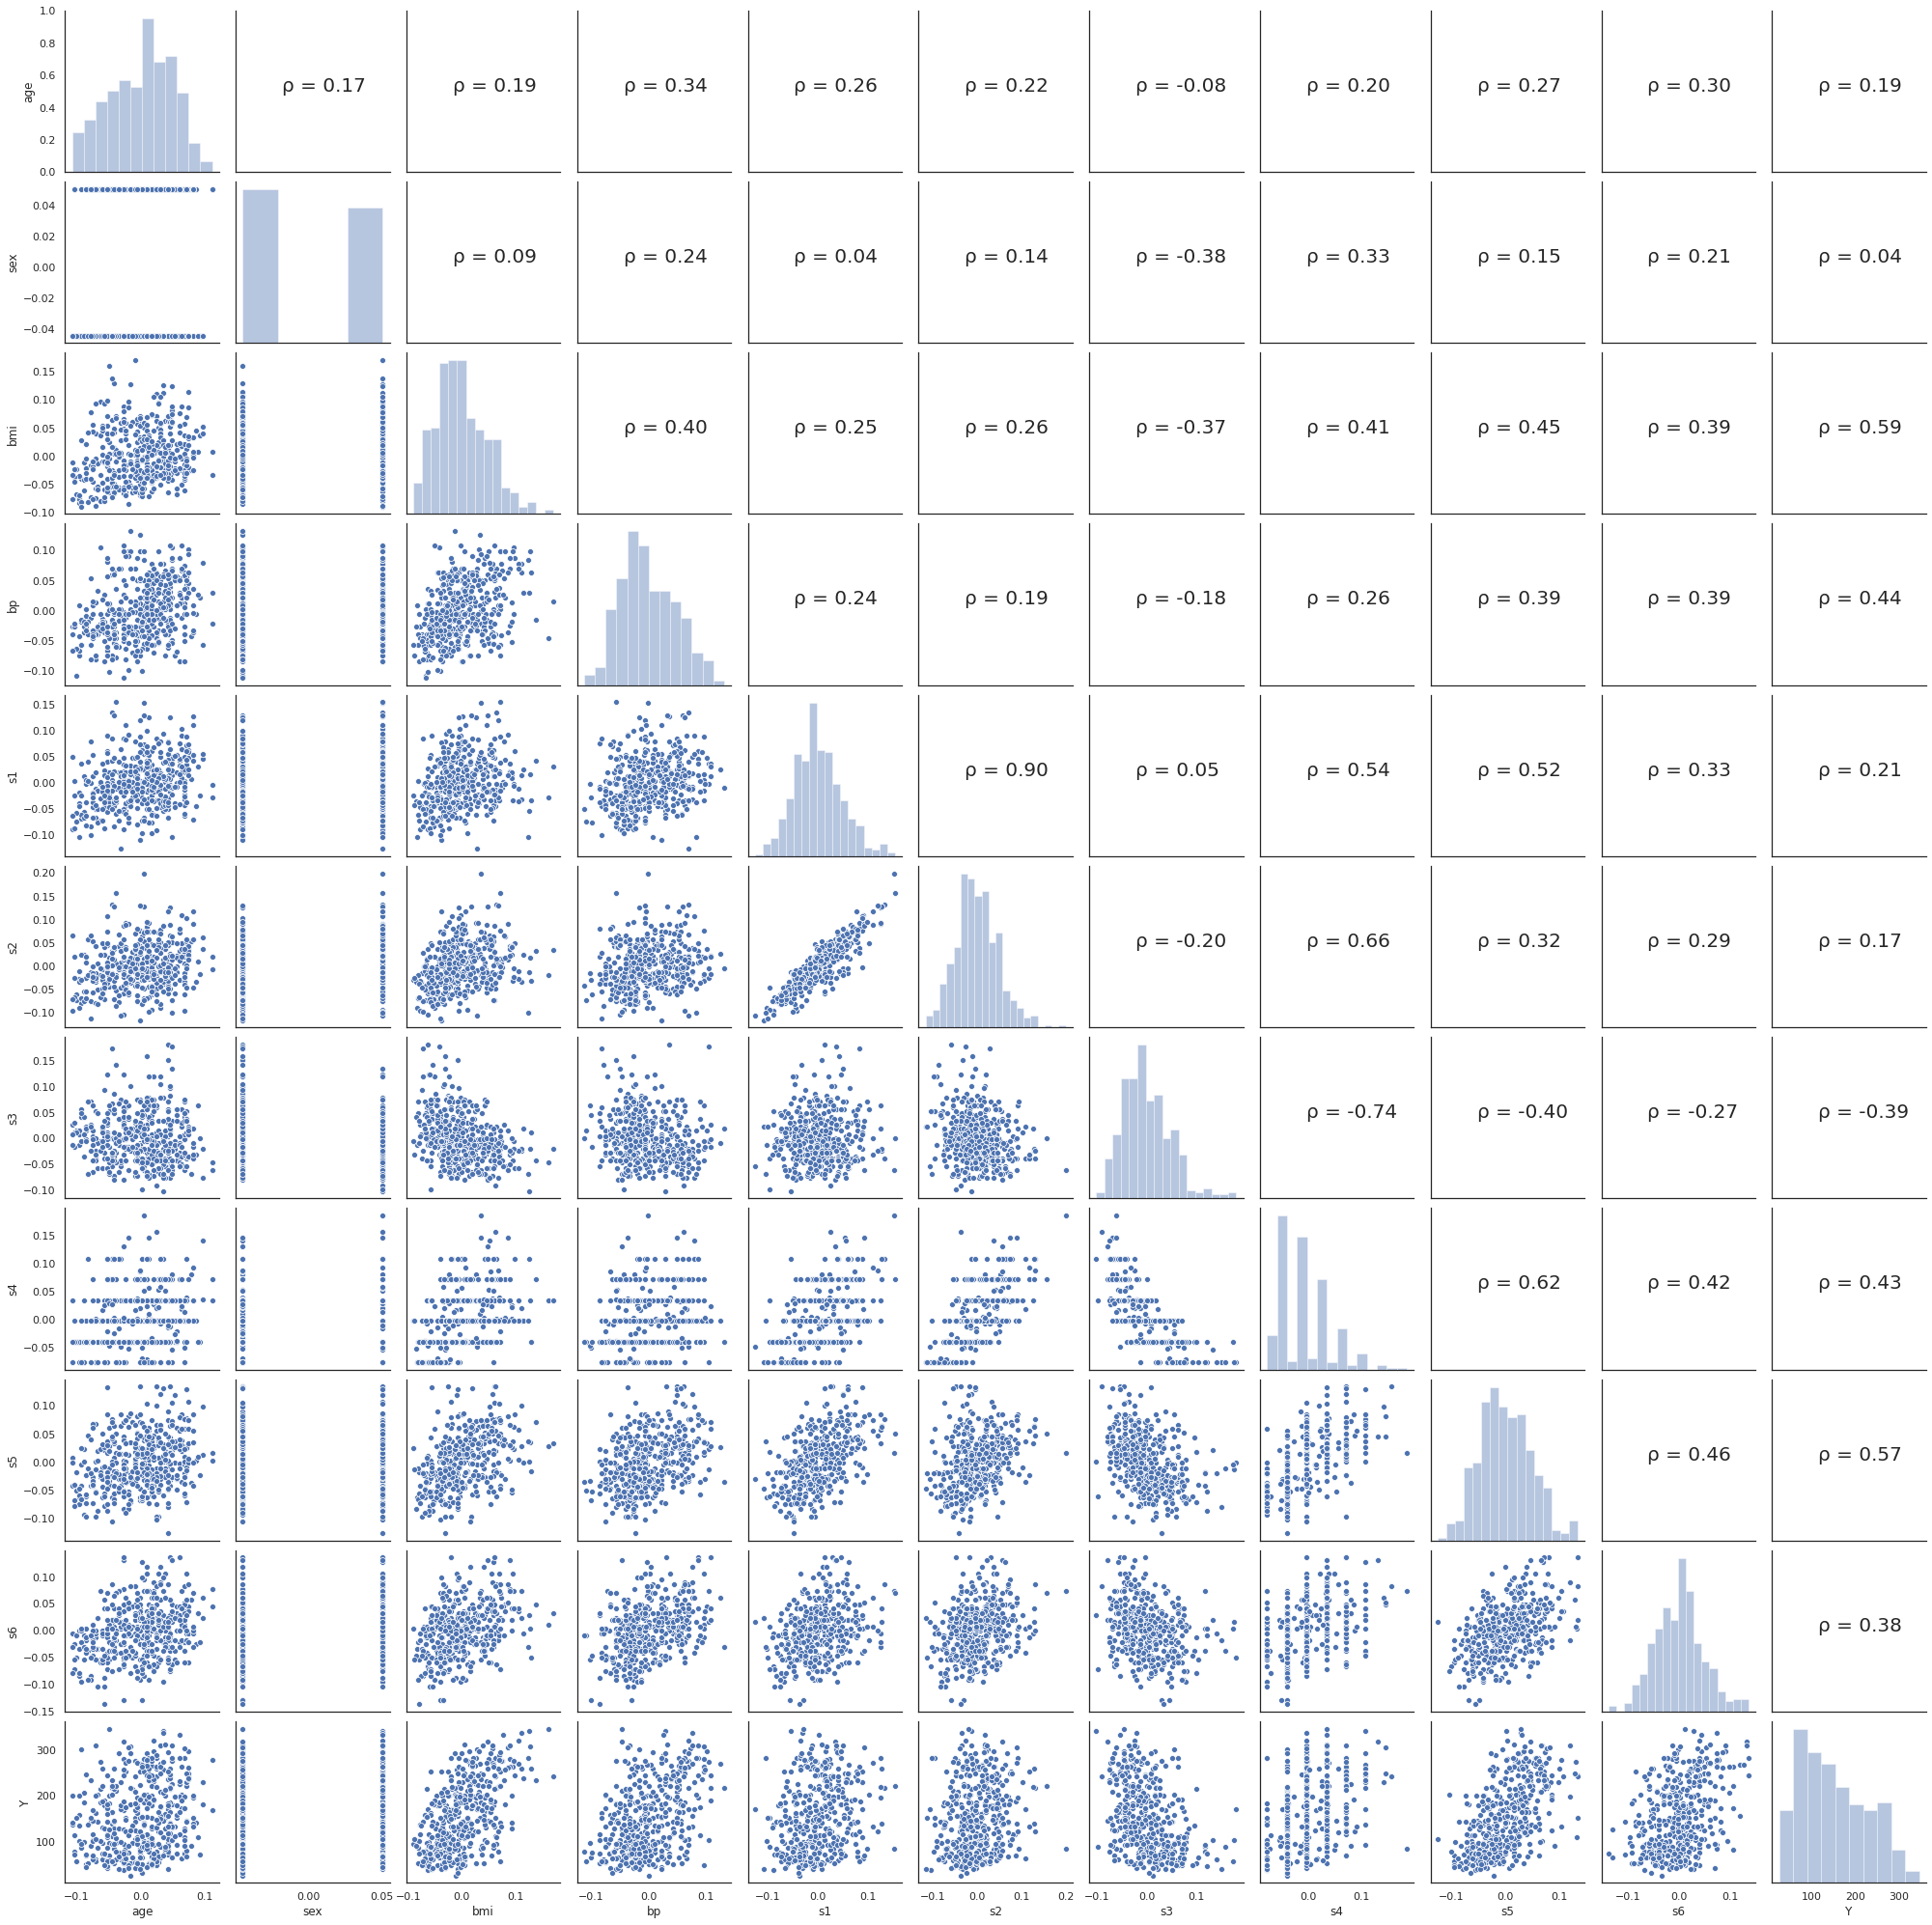

In [5]:
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.scatterplot, data=df)
g.map_diag(sns.distplot, kde=False)
g.map_upper(corrfunc) 

En los paneles que quedan hacia la esquina inferior izquierda se puede ver el gráfico de dispersión por par de variables, en los paneles de la diagonal central se ven los histogramas para cada variable y en los paneles de la esquina superior derecha, las correlaciones entre los pares de variables.

En primer lugar, se resalta que ninguna de las covariables tiene una correlación especialmente grande con la variable respuesta, pero hay varias con correlaciones muy bajas como age, sex, s1 y s2; por lo que se supone estas no seran relevantes a la hora de ajustar el modelo.

## Transformaciones a considerar

Se evaluan las siguienes transformaciones sobre las covariables y la variable respuesta para ver si mejoran el pronóstico del modelo:

- $p(w) = w$ (Función identidad, la variable se añade tal cual al modelo).
- $q(w) = \ln(w+0.5)$ Se suma 0.5 para evitar errores por valores negativos en las covariables. 
- $r(w)= \exp(w)$ 
- $s(w) = \sqrt{w+0.5}$
- $t(w) = y^{-1}$
- $u(w) = {y}^2$


In [0]:
## Transform 
def transform(x, fun = 'p'):
  if(fun == 'q'):
    return np.log(x+0.5)
  
  elif(fun == 'r'):
    return np.exp(x)

  elif(fun == 's'):
    return np.sqrt(x+0.5)
  
  elif(fun == 't'): #
    return np.power(x, -1)

  elif(fun == 'u'):
    return np.power(x, 2)
  
  else:
    return x

## Get original value
def inv_transform(x, fun = 'p'):
  if(fun == 'q'):
    return np.exp(x) - 0.5
  
  elif(fun == 'r'):
    return np.log(x) 

  elif(fun == 's'):
    return np.power(x, 2) - 0.5
  
  elif(fun == 't'):
    return np.power(x, -1) 

  elif(fun == 'u'):
    return np.power(x, 1/2)
  
  else:
    return x


func = ['p','q', 'r', 's', 't', 'u'] ## list of functions



Ademas, se escala la variable respuesta para mejorar las estimaciones de los modelos, se utiliza el clásico escalador min-max de manera que $Y$ tomará valores entre 0 y 1. 

Además, se resalta que sexo es dicotomica, por lo que no se utilizarán transformaciones y se reemplazan sus valores con 0 y 1, de manera que represente una variable indicadora en el modelo, -0.0446 será 0 y 0.0507 será 1.


In [0]:
# Diccionario donde se guardan minimos y maximos del escalado para cada una de las funciones
min_max = {}

# Añadimos minimos y maximos al diccionario
for f in func:
  transf = transform(df[['Y']],fun = f)
  min_max[f] = [np.min(transf), np.max(transf)]




#Funcion de escalado
def scale(y, fun):
  min = (min_max[fun])[0]
  max = (min_max[fun])[1]

  return((y-min)/(max-min))

#Funcion de desescalado 
def unscale(y, fun):
  min = (min_max[fun])[0] #removed .values
  max = (min_max[fun])[1] #removed .values
  return((y*(max-min))+min)

def sex01(sex= df[['sex']]):
  return(np.ceil(sex)) # ceil maps -0.0446 to 0 and 0.0507 to 1.


  

A continuación, se contruira el conjunto de datos con las transformaciones aplicadas a las covariables:

In [136]:

df_esc = pd.DataFrame()
for col in df:
  if col != 'Y' and col != 'sex':
    for fun in func:
      df_esc[fun + "(" + col+")"] = transform(df[col], fun) # Se anade a cada columna la transformacion

covs_to_scale = df_esc.columns #lista de columnas de variables numericas a escalar

df_esc['sex'] = sex01()
#df_esc['Y'] = norm_y(df[['Y']])
df_esc['Y'] = (df[['Y']])
df_esc


Index(['p(age)', 'q(age)', 'r(age)', 's(age)', 't(age)', 'u(age)', 'p(bmi)',
       'q(bmi)', 'r(bmi)', 's(bmi)', 't(bmi)', 'u(bmi)', 'p(bp)', 'q(bp)',
       'r(bp)', 's(bp)', 't(bp)', 'u(bp)', 'p(s1)', 'q(s1)', 'r(s1)', 's(s1)',
       't(s1)', 'u(s1)', 'p(s2)', 'q(s2)', 'r(s2)', 's(s2)', 't(s2)', 'u(s2)',
       'p(s3)', 'q(s3)', 'r(s3)', 's(s3)', 't(s3)', 'u(s3)', 'p(s4)', 'q(s4)',
       'r(s4)', 's(s4)', 't(s4)', 'u(s4)', 'p(s5)', 'q(s5)', 'r(s5)', 's(s5)',
       't(s5)', 'u(s5)', 'p(s6)', 'q(s6)', 'r(s6)', 's(s6)', 't(s6)', 'u(s6)'],
      dtype='object')

Y luego se escalan las transformaciones:

In [0]:
## Añadiendo escalado min max de exacalado para covariables
for cov in covs_to_scale:
  min_max[cov] = [np.min(df_esc[cov]), np.max(df_esc[cov])]


for cov in covs_to_scale:
  df_esc[cov] = scale(df_esc[cov], cov)


## **Modelo lineal**

Para el ajuste del modelo lineal se utilizará la clase `sklearn.linear_model.LinearRegression()`. Se determinara que parámetros incluir en el modelo partiendo aleatoriamente el conjunto de datos en _entrenamiento_ y _test_, correspondientes al 80% y 20% de los datos respectivamente. 

La selección de que covariables incluir en el modelo se hará al estilo de un _step forward_. Se empieza con un modelo sin covariables, y se evaluarán una por una y aquel que logre reducir más el error cuadrático medio para el conjunto de entrenamiento y validación será incluida en el modelo. Luego se repite el proceso añadiendo otras covariables hasta alcanzar un número de parámetros de interés.

Se destaca que el error cuadrático medio presentado no tiene en cuenta grados de libertad, si no que se utiliza directamente el número de datos: $MSE = n^{-1}\times\sum_{i=1}^n (y_i- \widehat{y_i})^2$


In [153]:
modelos_considerados = pd.DataFrame(columns= ["Modelo", "MSE_entrenamiento",
                                   "MSE_validacion", "cols"]) ## Matriz donde se guardan los modelos para su elección.
#lista de columnas con los nombres de las variables 
columnas = df_esc.columns[0:(len(df_esc.columns)-1)]
features = [] # Objeto donde se guardan las covariables utilizadas.

## Semilla para garantizar replicabilidad
np.random.seed(seed=433)

## indices del conjunto de testeo
indices = np.random.rand(len(df_esc)) < 0.8
train = df_esc[indices]
test = df_esc[~indices]

X_train = None
#X_test = None
Y_train = train[["Y"]] 
Y_test = (test[["Y"]])

## mejor modelo
best_mod = None
best_mse_tr = 100000000
best_mse_val = 100000


# se consideran modelos con a lo sumo 15+1 parámetros
for i in range(0,16): #se chequea la adición de hasta 20 covariables
  bestX = None 

  for col in columnas:
    
    if X_train is None:
      X_temp = train[[col]].copy()
    else:
      X_temp = X_train.copy()
      X_temp[col] = train[[col]]
      
    mod = LinearRegression().fit(X_temp, Y_train)
    mse_train = np.sum(np.power((mod.predict(X_temp)) - (Y_train), 2))/len(Y_train)
    
    mse_val =  (np.sum(np.power(mod.predict((test[X_temp.columns])) - Y_test,2))/len(Y_test)).values
    #print(mse_val < best_mse_val)
    #print(mse_val)
    if mse_val < best_mse_val:
      bestX = X_temp.copy() # se actualiza las mejores covariables con la nueva covariable
      best_mod = mod
      best_mse_tr = mse_train
      best_mse_val = mse_val

  X_train = bestX.copy()
  modelos_considerados= modelos_considerados.append({
      "Modelo": best_mod,
       "MSE_entrenamiento": best_mse_tr,
       "MSE_validacion": best_mse_val, 
       "cols": bestX.columns 
  }, ignore_index=True)
  


modelos_considerados.loc[:,modelos_considerados.columns.difference(["Modelo"])]



,MSE_entrenamiento,MSE_validacion,cols
0,Y 4122.6712 dtype: float64,[3641.608284265017],"Index(['p(s5)'], dtype='object')"
1,Y 3229.4687 dtype: float64,[3075.1408113731463],"Index(['p(s5)', 'r(bmi)'], dtype='object')"
2,Y 3121.7936 dtype: float64,[2861.8966639432115],"Index(['p(s5)', 'r(bmi)', 'r(bp)'], dtype='obj..."
3,Y 3054.6797 dtype: float64,[2789.7404019700684],"Index(['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)'], d..."
4,Y 3023.6874 dtype: float64,[2733.5567053385394],"Index(['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)', 'u..."
5,Y 2961.4990 dtype: float64,[2684.3701538737932],"Index(['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)', 'u..."
6,Y 2959.6452 dtype: float64,[2658.784138178883],"Index(['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)', 'u..."
7,Y 2951.6960 dtype: float64,[2637.3517023293844],"Index(['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)', 'u..."
8,Y 2913.6492 dtype: float64,[2615.040075731366],"Index(['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)', 'u..."
9,Y 2893.3473 dtype: float64,[2593.963733290536],"Index(['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)', 'u..."


En la tabla anterior se muestran los modelos considerados, se pueden ver bajones drásticos en los MSE en entrenamiento y vaidación hasta el modelo 6, a partir de ahí la disminución del MSE se reduce (disminuyendo en ordenes de 20 o menos frente al anterior modelo).

In [154]:
print("Los parámetros incluidos en el modelo 6 son:")
mod_l = modelos_considerados.loc[6,"cols"]
print(mod_l)
print("Los parámetros incluidos en el modelo 11 son son:")
print(modelos_considerados.loc[11,"cols"])

Los parámetros incluidos en el modelo 6 son:
Index(['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)', 'u(age)', 'u(s6)', 't(s4)'], dtype='object')
Los parámetros incluidos en el modelo 11 son son:
Index(['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)', 'u(age)', 'u(s6)', 't(s4)',
       'p(bmi)', 'r(s4)', 't(age)', 'p(bp)', 't(s5)'],
      dtype='object')


En la anterior salida se puede apreciar que a partir del modelo 7 no se incluye ninguna variable que ya no estuviera en el modelo, si no que se incluyen transformaciones de variables ya presentes. Por lo que se decide que las variables significativas con su respectiva transformación son: ['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)', 'u(age)', 'u(s6)', 't(s4)'], es decir, tan solo se descartan s2 y s3. Ademas, se encontró que la mejor transformación para la $y$ fue $p$ es decir la identidad.

In [155]:
X_train = X_train[['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)', 'u(age)', 'u(s6)', 't(s4)']]
X_test = test[['p(s5)', 'r(bmi)', 'r(bp)', 'p(s1)', 'u(age)', 'u(s6)', 't(s4)']]
X_train.head(3)


,p(s5),r(bmi),r(bp),p(s1),u(age),u(s6),t(s4)
0,0.5622,0.5507,0.5190,0.2941,0.1180,0.0163,0.1388
1,0.2224,0.1328,0.3246,0.4216,0.0000,0.4479,0.2369
2,0.4966,0.4840,0.4067,0.2892,0.5933,0.0354,0.1388


## **Ajuste Red neuronal**

Se ajustó una red neuronal para compararla con el modelo de regresión, usando `sklearn.neural_network.MLPRegressor()`, con el mismo conjunto de validación y de entrenamiento con el que se ajustó el modelo de regresión.

Para optimizar la red neuronal se variaron el número de nodos y capas ocultas, tras probar varias veces se encontró que aumentar el número de capas por encima de 2 empeoraba el ajuste. Se variaron el número de nodos de las capas entre 2 y 8. Además, la red no cambiaba sus pronósticos al modificar el momentum (sus pesos parecen converger al mismo valor independiente de este parámetro). Finalmente, se variaron la función de activación ("relu", "logistic", "identity") y el optimizador ("adam", "sgd").

In [0]:
max_nodos = 8
min_nodos = 2

learning_rate_init = np.arange(0.01, 0.1, 0.1)
momentum = np.arange(0.1, 0.91, 0.15)

## best neural network
best_mse = 1000000
best_mod = None
mse_list = []
opt = ["adam", "sgd"]
act = ["relu", "logistic", "identity"]


f = "p"
y_test = scale(transform(Y_test, f), fun = f)
y_train = scale(transform(Y_train, f), fun = f)

for nod_l1 in range(min_nodos, max_nodos + 1):
  for nod_l2 in range(1, nod_l1+1):
    for lr in learning_rate_init:
      for activ in act:
        for op in opt:
          n_net = MLPRegressor(
              hidden_layer_sizes=(nod_l1, nod_l2),
              activation = activ,
              learning_rate = 'adaptive',
              momentum = 0.5,
              learning_rate_init = lr,
              random_state = 111,
              max_iter = 100000,
              solver=op
              )
          n_net.fit(X_train, (y_train)['Y'].to_list() )

          y_est = inv_transform(unscale(pd.DataFrame(n_net.predict(X_test), columns = ["Y"]), "p"), f)
          
          mse = np.mean(np.power(np.subtract((Y_test),pd.DataFrame(y_est)), 2))
          mse_list.append(mse)

          if (mse.item() < best_mse):
            best_mod = n_net  
            best_mse = mse.item()



Se encuentra que el MSE de validación para la mejor red neuronal fue:

In [254]:
best_mse

2511.2209234895467

Es decir que su MSE de validación fue mejor que el de todos los modelos de regresión ajustados. Algunas características de la red neuronal son:

In [256]:
print("Número de nodos por capa:", best_mod.hidden_layer_sizes)
print("learning rate:", best_mod.learning_rate_init)
print("optimizador:", best_mod.solver)
print("Función de activación:", best_mod.activation)

Número de nodos por capa: (8, 5)
learning rate: 0.01
optimizador: adam
Función de activación: relu


## Conclusiones
- Se pudo encontrar una mejoría significativa en el ajuste de el avance de la diabetes según el indicador $Y$ ajustando una red neuronal, frente a una regresión lineal.
- Si bien no se presentan los modelos ajustados sin modificar las covariables. Realizar las transformaciones y el escadalo de estas, mejoro notablemente el pronóstico de ambos, el modelo de regresión y la red neuronal; particularmente en esta última el cambio fue drástico, pasando de MSE del orden de 6000 a inferiores de 3000, por lo que los modelos de redes neuronales son más sencibles que las técnicas de regresión al escalado de los datos.